**Содержание темы**

1. Теория
2. [Практический ноутбук 1](https://colab.research.google.com/drive/1dri4Nx0VNsF9vZmF-qjN12AZBJ-eAdlY?usp=sharing)
3. [Практический ноутбук 2](https://colab.research.google.com/drive/1xJnAZG5CY1sZftGGG5Qq5Ze-ZveYHcRH?usp=sharing)


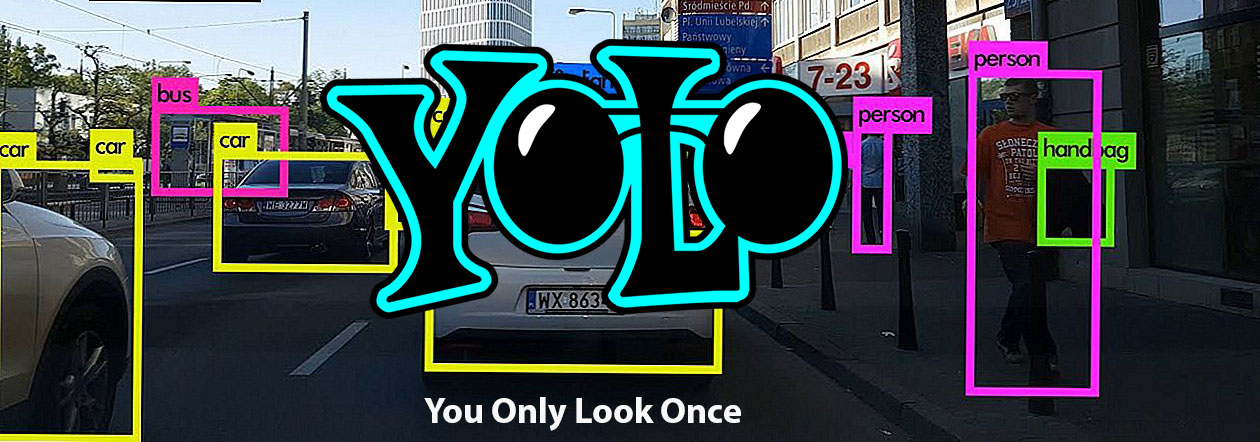

В этом уроке вы узнаете:
- Модель YOLOv3 на основе сверточной нейронной сети DarkNet53
- Лучшая в своем классе реализация библиотеки YOLOv3 с открытым исходным кодом для библиотеки глубокого обучения Keras.
- Как использовать предобученную сеть YOLOv3 для обнаружения объектов


## Вступление
<p>Обнаружение объектов — это задача компьютерного зрения, которая включает в себя как локализацию одного или нескольких объектов на изображении, так и их классификацию.

<p>Семейство моделей <b>«You Only Look Once»</b> или <b>YOLO</b> - это серия моделей сквозного глубокого обучения, разработанных Джозефом Редмоном и др. для обнаружения объектов в реальном времени. Она была впервые представлена в статье 2015 года под названием <a href='https://arxiv.org/abs/1506.02640'>«Ты смотришь только раз: унифицированное обнаружение объектов в реальном времени». 

<p>Подход включает единую глубокую сверточную нейронную сеть. Первоначально использовалась <b><i>GoogLeNet</b></i>, во второй версии на нейросеть собственного дизайна <b><i>DarkNet</b></i> на основе сети VGG. 

Кратко процесс детектирования можно описать так: 
- входное изображение разбивается на квадраты или, используя терминологию оригинального документа, якорные бокы (anchor box), 
- каждый анкор бокс напрямую предсказывает ограничивающую рамку и классифицирует объект или объекты. 

В результате получается большое количество ограничивающих рамок-кандидатов, которые объединяются в окончательный прогноз на этапе постобработки.

В настоящей момент существуют четыре основных варианта:

- YOLOv1 предложила общую архитектуру и подход YOLO. 

- YOLOv2 (она же YOLO9000), Существенно переработан дизайн, введено понятие якорных боксов (анкор боксы) для улучшения локализации ограничивающей рамки, изменена базовая нейронная сеть с GoogLeNet на Darknet19, а также предпринята попытка переосмыслить подход к классификации объектов. Пожалуй, одно это заслуживает отдельного упоминания и рассмотрения, что и будет сделано ниже.

- YOLOv3. Вместо Darknet19 была предложена новая, расширенная архитектура Darknet53 (цифра означает количество сверточных слоев в модели) и использован, ставший уже стандартом по умолчанию, подход остаточных блоков, вдохновленный сетью ResNet. Так же был изменен процесс обучения.

- YOLOv4 вобрала в себя следующие функции: `Weighted-Residual-Connections(WRC)`(взвешенные остаточные соединения), `Cross-Stage-Partial-connections (CSP)`(межэтапные частичные соединения), `Cross mini-Batch
Normalization (CmBN)`(кросс-мини-пакетную нормализацию), `Self-adversarial-training (SAT)`(самосостязательное обучение) и Mish активацию. 

На сегодняшний день, рассмотривать ранние версии YOLO нет смысла, так как все важные идеи и основная концепция воплотились в <b>YOLOv3</b>. Именно на ее базе строятся дальнейшие улучшения. Поэтому изучение подхода <b>YOLO</b> мы начнем именно с третьей версии.

Всю систему можно разделить на два основных компонента: Экстрактор (получение карт признаков) и Детектор (получения ограничивающих рамок и информации о классах).

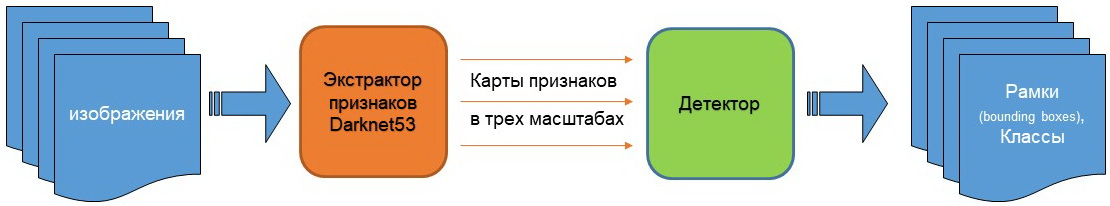
<br><b>Рисунок 1</b>

## Экстрактор 


<p>Как уже упоминалось выше, предыдущая версия YOLO использовала сеть <b>Darknet-19</b>. Но это было несколько лет назад и сети классификации изображений сильно продвинулись вперед от простых DeepCNN (глубоких сверточых сетей). <b>ResNet</b> предложил идею пропускных соединений (skip connection), чтобы помочь распространению активаций(извлеченной информации) через более глубокие слои без уменьшения градиента (без потери информации). Разработчики <b>YOLO</b> заимствует эту идею и успешно расширяют сеть с 19 до 53 слоев, создав <b>Darknet-53 </b> 


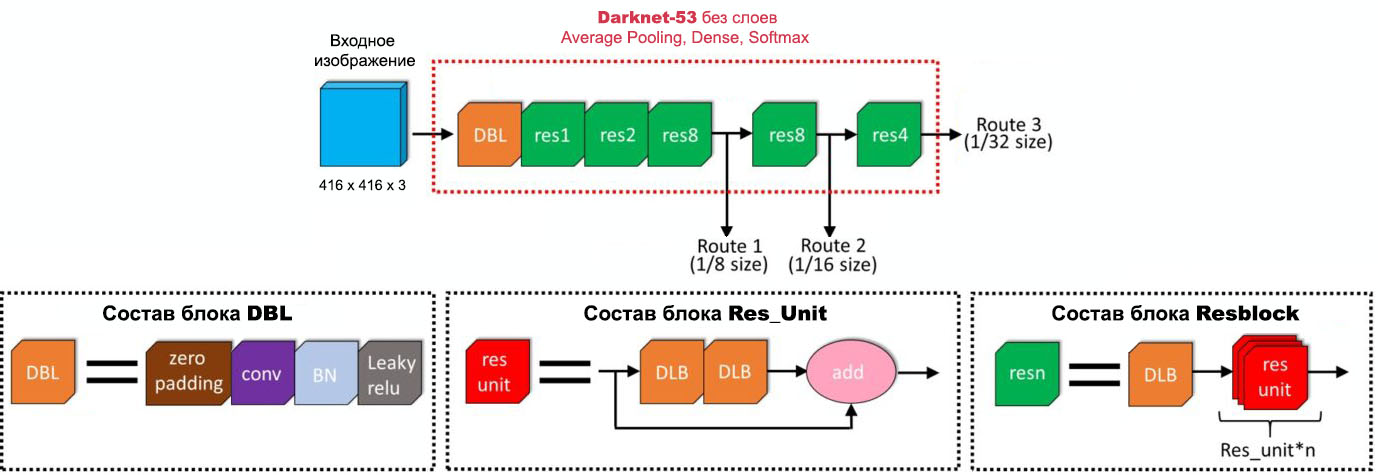<br><b>Рисунок 2: </b> Блок схема сети <b>Darknet-53</b>

Ниже приведен послойный состав сети Darknet-53 из оригинального документа. Вообще, описание сети Darknet-53 в оригинальном документе ограничивается таблицей 1. Восстановить по ней реальный состав сети довольно занятная задача.

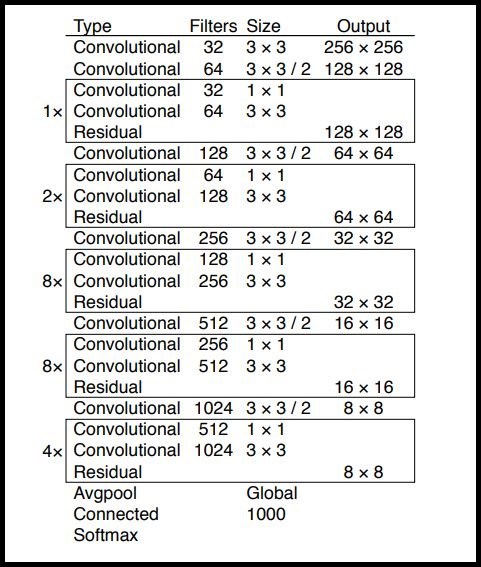
<br><b>Таблица 1</b>

#### Функция DBL

Модель Darknet, подобно модели VGG, в основном использует ядро свертки 3х3, но так же, используя наработки NIN (<a href ='https://arxiv.org/abs/1312.4400' target='blank'>Network in Network(сеть в сети)</a>), между слоями с ядром 3х3,  используется ядро 1х1 для сжатия карт признаков между слоями свертки. Как видно из рисунка 3, сеть удобно собирать, пользуясь типовыми блоками, ниже приведены функции, которые реализуют эти блоки.  






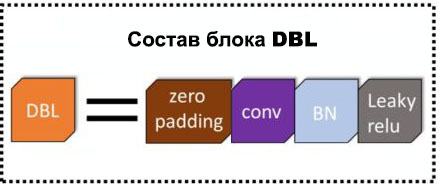<br>
<b>Рисунок 3:</b> блок схема функции DBL

**Аргументы функции:**

Если шаг свертки `Stride = 2`, то перед созданием сверточного слоя (перед уменьшением дискретизации) во входной тензор (изображение или карта признаков), при помощи слоя `ZeroPadding2D`, добавляется отступ из нулей, что бы ядро светки лучше захватило верхний левый угол тензора.

Если шаг свертки `Stride = 1`, то сразу создается сверточный слой с заданными параметрами.

Так же надо помнить, что в Keras, если активационная функцию не указана явно, то по умолчанию используется линейная ф-я активации. Соответственно, когда переменная `batch_norm=False` используется функция активации `Linear` без нормализации.

Переменная `batch_norm` - boolean, включать ли ветку со слоем Batchnormalization и активационной функцией LeakyReLu. По умолчанию, эта пременная имеет состояние True, т.е. если переменная не перечислена явно в аргументах функции DBL, то по умолчанию она использует на выходе эту ветку. Применяется для стабилизации обучения, ускорения сходимости и регуляризации модели в слоях.

Отдельно надо сказать об аргументе `layer_idx`. Он используется во всех функциях из которых состоит модель YOLOv3 и задает сквозную нумерацию слоев. Это необходимо для адресной загрузки весов, от обученной модели, по слоям. Нумерация слоев начинается с нуля. Номер слоя, преобразуется в строку и добавляется к имени слоя.



In [ ]:
def DBL(x, filters, kernel, strides=1, batch_norm=True, layer_idx=None): # DarknetConv2D_BN_Leaky
   
    '''
    Функция реализует блок DBL в составе моделей Darknet и YOLO
    
    Args:
        x - тензор входных данных
        filter - количество фильтров на слой, целое число
        kernel - размер ядра свертки, целое число
        stride - шаг свертки, целое число
        batch_norm - включать или ветку со слоем Batchnormalization и активационной функцией LeakyReLu. 
        layer_idx - номер слоя
    Return:
        x - тензор выходных данных
        layer_idx+1 -номер следующего слоя

    '''
    
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # Делаем oтступ в виде нулей по контуру изображения, что бы захватить левый верхний угол
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=kernel,
              strides=strides, padding=padding,
              use_bias=not batch_norm, kernel_regularizer=l2(0.0005), name='conv_' + str(layer_idx))(x)
    if batch_norm:
        x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(layer_idx))(x)
        x = LeakyReLU(alpha=0.1,name='leake_' + str(layer_idx))(x)
    
    return x, layer_idx+1

####  Функция Res_unit

Функция <b>Res_unit</b> (рис. 4) реализует минимальную ячейку Residual блока (блок с т.н. остаточными данными). 

Слои свертки извлекают из изображения карты признаков. И объединение с остаточными данными в конце позволяет сохранять входящую информацию об изображении в очень глубоких сетях.

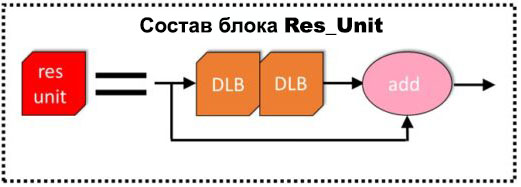<br>
<b>Рисунок 4:</b> блок схема функции Res_unit

Функция `Res_unit` использует функцию `DBL` определенную выше, создающую два серточных слоя Conv2D идущих подряд с разными настройками количества фильтров и ядра свертки.

**Аргументы функции:**

Параметры ядра свертки `kernel` задаются жестко внутри функции.

Шаг свертки <`stride = 1`, установлен по умолчанию в функции DBL и не изменяется.

На входе функции создается прямое соединение `skip_connection` с выходом. 

Входной тензор `x`, пройдя два сверточных слоя, объединяется с неизменным входным тензором `skip_connection` при помощи метода `Add` и подается на выход функции. Так же на выход функции подается номер следующего слоя.

In [ ]:
def Res_unit(x, filters, layer_idx): # DarknetResidual

    '''
    Функция определяет минимальную ячейку Residual блока
    
    Args:
        x - тензор входных данных
        filter - количество фильтров на слой, целое число
        layer_idx - номер слоя
    Return:
        x - тензор выходных данных
        layer_idx+1 - номер следующего слоя

    '''

    skip_connection = x
    x, layer_idx = DBL(x, filters // 2, kernel=1, layer_idx=layer_idx)
    x, layer_idx = DBL(x, filters, kernel=3, layer_idx=layer_idx)
    x = add([skip_connection , x], name='Add_'+str(layer_idx))

    return x, layer_idx+1

#### Функция ResBlock

Функция <b>ResBlock</b> реализует Residual блок заданных размеров. Сеть Darknet использует Residual блоки кратностью $\times1, \times2, \times4, \times8$. Функция использует определённые выше функции <b>DBL</b> и <b>Res_unit</b>. Функция сконструирована так, что входной тензор x подается на сверточный слой Conv2D с ядром свертки 3х3 и шагом свертки 2, т.е. его размерность уменьшается в два раза, затем он проходит  n  residual блоков.


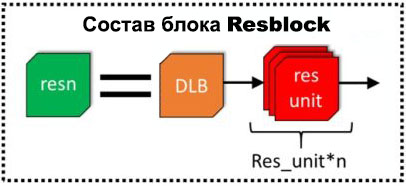<br><b>Рисунок 5:</b> Блок схема функции ResBlock

In [ ]:
def ResBlock(x, filters, blocks, layer_idx): # DarknetBlock

    '''
    Функция определяет Residual блок состоящий из входного сверточного слоя 
    и последовательности Res_unit блоков
    
    Args:
        x - тензор входных данных
        filters - задает количество фильтров
        block - задает количество Residual 'ячеек', а именно, сколько раз повторить в цикле функцию Res_unit
        layer_idx - номер слоя
    Return:
        x - тензор выходных данных
        layer_idx -номер слоя

    '''

    x, layer_idx = DBL(x, filters, kernel=3, strides=2, layer_idx=layer_idx)
    
    for _ in repeat(None, blocks):
        x, layer_idx = Res_unit(x, filters, layer_idx=layer_idx)
    
    return x, layer_idx

> <b>Обратите внимание.</b> Использование функции <b>repeat</b> в цикле <b>for</b> позволявет экономить ресурсы памяти

### Резюме

Каскад сверточных слоев (DBL) и остаточных блоков (ResBlock) "выжимает" визуальную информацию из изображения (форма объектов, цвет, яркость, и т.д.). 
Поэтому сеть Darknet без классификационных выходных слоев называют экстрактор. Всё, что нейросеть сумеет извлечь из изображения, будет записано в тензор - карту признаков `features maps`.


Если бы цель состояла в том, чтобы выполнить мульти-классовую классификацию на наборе данных ImageNet, то сеть Darknet-53 выглядела бы как в ячейке ниже (в конце со слоями Average pooling и Dense на 1000 нейронов, с активацией softmax на выходе).

В архитектуре YOLO используются другой подход.

In [ ]:
# Слои нейронной сети
from tensorflow.keras.layers import Input  

# регуляризатор, который применяет штраф за регуляризацию L2
from tensorflow.keras.regularizers import l2 

# итератор, повторно возвращающий указанный объект 
from itertools import repeat

# работа со слоями
from tensorflow.keras.layers import add, concatenate

# создание моделей
from keras.models import Model

In [ ]:
 # Так бы выглядела Сеть Darknet 53 если бы ее использовали отдельно

layer_idx = 0
input_image = Input(shape=(416, 416, 3))
x, layer_idx = DBL(input_image, filters=32, kernel=3, strides=1, layer_idx=layer_idx)       
x, layer_idx = ResBlock(x, filters=64, blocks=1, layer_idx=layer_idx)          
x, layer_idx = ResBlock(x, filters=128, blocks=2, layer_idx=layer_idx)          
x, layer_idx = ResBlock(x, filters=256, blocks=8, layer_idx=layer_idx)        
x, layer_idx = ResBlock(x, filters=512, blocks=8, layer_idx=layer_idx)        
x, layer_idx = ResBlock(x, filters=1024, blocks=4, layer_idx=layer_idx)       
x, layer_idx = DBL(x, filters=1024, kernel=1, strides=1, layer_idx=layer_idx)

model = Model (input_image, x)

model.summary()

Из-за особенностей нумерации слоёв кажется, что в модели <b>Darknet-53</b> сверточных слоев больше чем 53. Нюанс заключается в том, что нумеруются не только <b>Conv</b> слои, но и функция <b>Add</b>. Как уже упоминалось выше, это связано с особенностью загрузки весов в готовую модель.

## Детектор

Для повышения качества распознавания объектов (особенно мелких) в YOLOv3 используется детекция в нескольких масштабах. Чтобы это реализовать, сделаны дополнительные выходы со соответствующих слоев Экстрактора (рисунок 6).

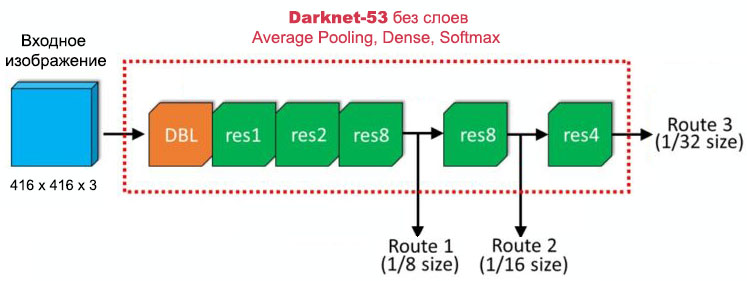
<br><b>Рисунок 6:</b> Сеть Darknet с дополнительными выходами

**Важно!** Базовый размер изображения, который используется в YOLOv3 - 416х416 пикселей, поэтому размеры карт признаков указаны именно для входного изображения такой формы (см. рисунок 7).

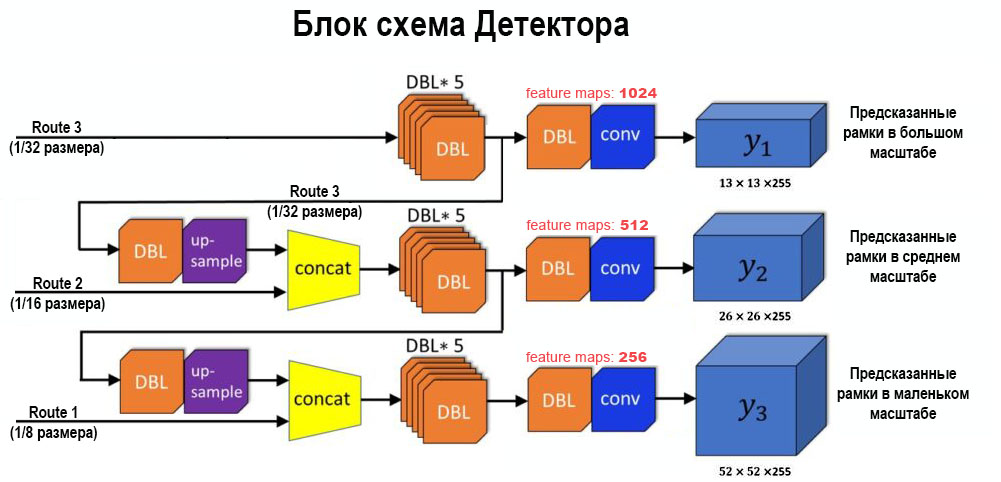

Рисунок 8. Блок-схема многоуровнего детектора

### Функция Detector

Условие в начале реализует возможность работать как с одним тензором, так и со списком из двух. Если на вход поступает список, то внутри Детектора список разделяется на два отдельных тензора. 

Первый тензор, пришедший с более глубоких слоев, сначала проходит через сверточный слой и слой повышающей дискретизации `UpSampling2D`, чтобы его форма стал такой же, как у второго тензора. 

Затем оба тензора, подаются в функцию конкатенации.

На последнем этапе выходной тензор проходит предпоследний сверточный слой и поступает на выходной сверточный слой, который имеет конкретную размерность, зависящую от количества закодированных классов. 


Итак на выходе имеем тензор следующей формы `(SхS, num_sub_anchors * (4 + 1 + num_classes)) = SxS, 3*(4+1+80)`, где: 

        - SxS - размер тензора; 
        - num_sub_anchors - количество анкор боксов (в классическом варианте 3шт);
        - 4 - 'координаты' для ограничивающией рамки (bounding box) (на самом деле не абсолютные координаты, а смещение относительно якорного поля (anchor boxes);
        - 1 - объектность т.е. вероятность того, что внутри рамки находится какой либо объект; 
        - num_classes- количество классов которое предсказывает модель (в нашем случае 80).

Итого, в нашем примере, на выходе будут получены тензоры следующей формы:
- 13х13х255 
- 26x26x255
- 52x52x255


In [ ]:
def Detector(x_in, filters, layer_idx=None):
   
    '''
    Функция реализует блок DBL в составе моделей Darknet и YOLO
    
    Args:
        x_in - тензор или список тензоров
        filters - количество фильтров
        layer_idx - номер следующего сверточного слоя
    Return:
        bboxes - рамки
        fork - тензор
        layer_idx -номер слоя

    '''

    if isinstance(x_in, list): # Если на вход поступает список попадаем в эту ветку (маршруты 2 и 3)
        x, x_skip = x_in[0], x_in[1]# Разбиваем список на отдельные тензоры
        x,layer_idx = DBL(x, filters, kernel=1, strides=1, layer_idx=layer_idx) # DarknetConv
        x = UpSampling2D(2, name = 'UpSampling_' + str(layer_idx))(x) # Повышаем размерность тензора
        layer_idx+=1
        x =concatenate([x, x_skip], name = 'Concatenate_' + str(layer_idx)) # Объединяем маршруты
        layer_idx+=1
        
        # Пять сверточных слоев DBL*5 
        for i in range(2):
          x, layer_idx = DBL(x, filters, 1, layer_idx=layer_idx)      # 1,3
          x, layer_idx = DBL(x, filters * 2, 3, layer_idx=layer_idx)  # 2,4
        
        fork, layer_idx = DBL(x, filters, 1, layer_idx=layer_idx)      # 5 С пятого слоя каскада делаем вилку на выход и на другой масштаб         
    
    else: # В эту ветку попадает только маршрут 1
        x = x_in
        
        # Пять сверточных слоев DBL*5 
        for i in range(2):
          x, layer_idx = DBL(x, filters, 1, layer_idx=layer_idx)      # 1,3
          x, layer_idx = DBL(x, filters * 2, 3, layer_idx=layer_idx)  # 2,4
        
        fork, layer_idx = DBL(x, filters, 1, layer_idx=layer_idx)      # 5 С пятого слоя каскада делаем вилку на выход и на другой масштаб 

    # Предпоследний сверточный слой (№80 13х13х1024, #92 26x26x512, #104 52x52x256)
    x,layer_idx = DBL(fork, filters=filters*2, kernel=3, strides=1, layer_idx=layer_idx)

    # Выходные слои (№81 13х13х (anchors * (4 + 1 + classes)), №93 26х26, №105 52х52 (255) 
    bboxes, layer_idx = DBL(x, filters=num_sub_anchors * (4 + 1 + num_classes), kernel=1, strides=1, batch_norm= False, layer_idx=layer_idx)       

    return bboxes, fork, layer_idx

### Резюме

Реализация итоговой архитектуры Darknet с дополнительными выходами приведена ниже:

In [ ]:
input_image = Input(shape=(None, None, 3))
 
layer_idx = 0 # Номер первого слоя
x, layer_idx = DBL(input_image, filters=32, kernel=3, layer_idx=layer_idx)         # Блок DBL
x, layer_idx = ResBlock(x, filters=64, blocks=1, layer_idx=layer_idx)              # Блок res1
x, layer_idx = ResBlock(x, filters=128, blocks=2, layer_idx=layer_idx)             # Блок res2
x, layer_idx = Route_1,_ = ResBlock(x, filters=256, blocks=8, layer_idx=layer_idx) # Блок res8 первый выход из сети с масштабом 52х52
x, layer_idx = Route_2,_ = ResBlock(x, filters=512, blocks=8, layer_idx=layer_idx) # Блок res8 второй выход из сети с масштабом 26х26
Route_3, layer_idx = ResBlock(x, filters=1024, blocks=4, layer_idx=layer_idx)      # Блок res4 трений выход из сети с масштабом 13х13

 Мы получаем карты признаков 52×52x256, 26×26x512, 13×13x1024 (рис. 7)

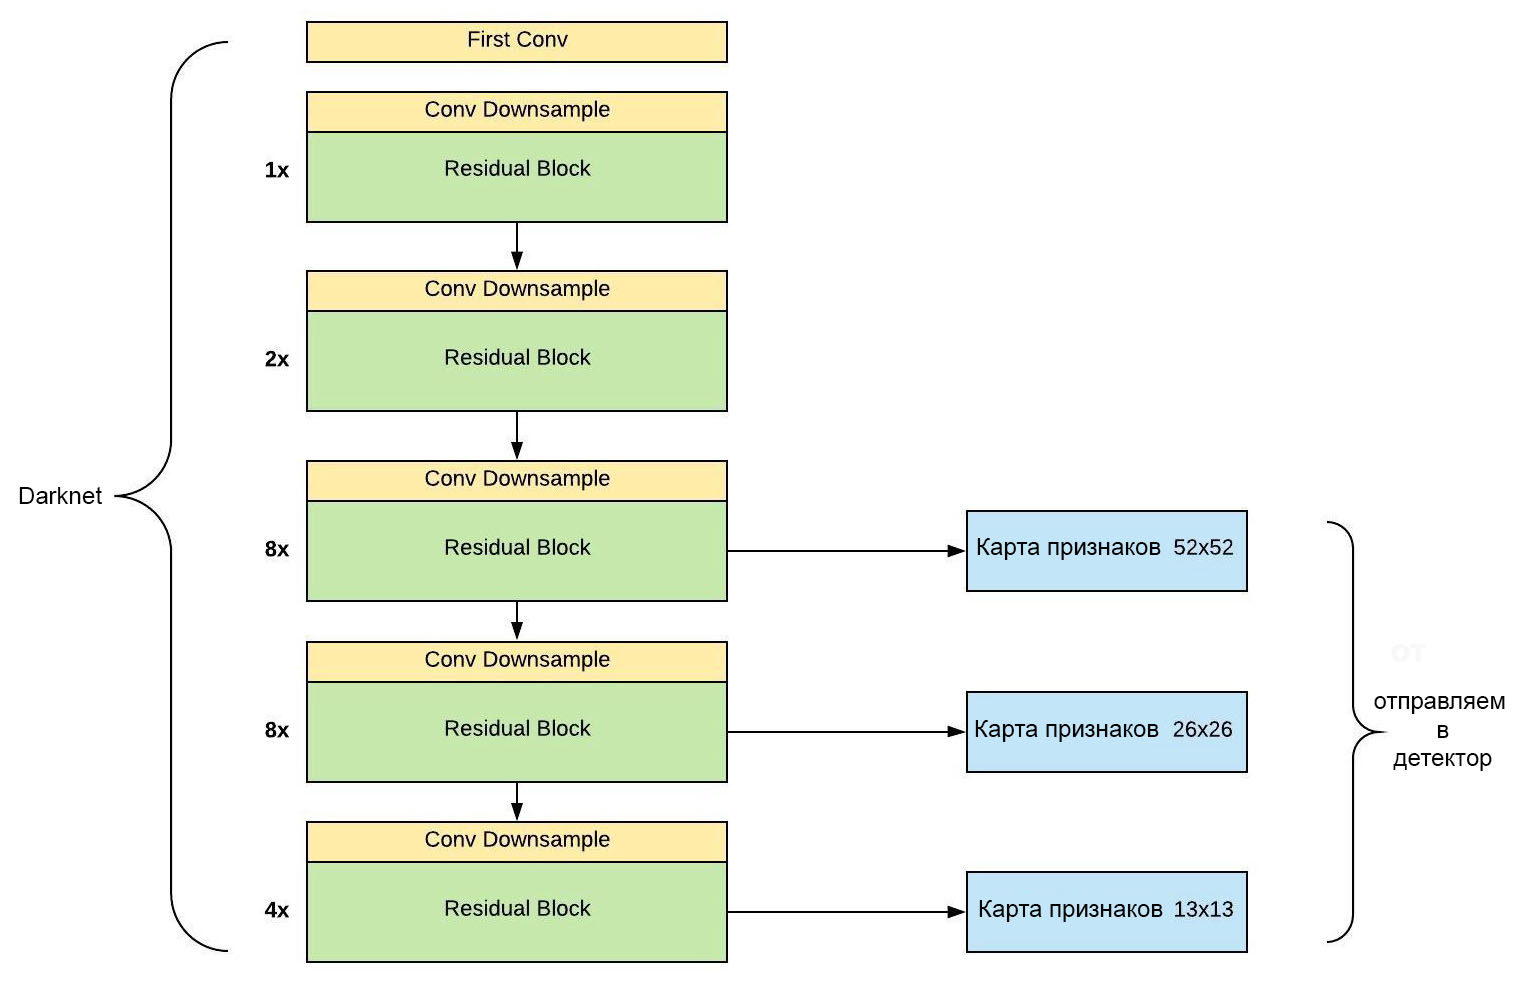

Рисунок 7. Выходы в 3-х масштабах с промежуточных слоев Darknet 

## Архитектура YOLOv3
Вся модель <b>Darknet53</b> состоит из стандартных блоков отличающихся друг от друга лишь количеством слоев и наличием прямого соединения. Структура модели и блоки из которых она состоит показаны на рисунке ниже

Модель **Darknet** предсказывает ограничивающие рамки в трех разных масштабах. Если идти от конца сетки к началу, то выход с последнего слоя будет иметь размер 13х13x255, что эквивалентно делению входного изображения сеткой с ячейкой 13х13.

К базовому экстрактору признаков (модель Darknet53) добавляют несоколько сверточных слоев. Последний из них предсказывает ограничивающую рамку, кадрируя ее 3-х мерным тензором + объектность + классы. В базовых настройках модель прогнозирует 3 рамки (bounding box) в каждом масштабе. 

Затем берется карта признаков из двух предыдущих слоев и карта признаков из предыдущей сети (Rout3), масштабируется в 2 раза и объединяется при помощи конкатенации. Этот метод позволяет получать более значимую семантическую информацию из масштабированных признаков и более детальную информацию (мелкие объекты) из более раннейе карты признаков. Далее добавляются еще несколько сверточных слоев для обработки этой объединённой карты признаков и, в конечном итоге, предсказываем аналогичный тензор (как описан выше), но в два раза больше.

Второй масштаб для средних объектов имеет выход со слоя 26х26х255, что эквивалентно сетке якорных ячеек (anchor box) 26х26.

Этот процесс повторяется еще раз, что бы предсказать рамки для третьего масштаба. Третий масштаб для мелких объектов имеет выход со слоя 52х52х255, что соответствует сетке якорых ячеек 52х52.

Таким образом, прогнозы для третьего масштаба выийгрывают благодаря всем предыдущим вычислениям и детализированным признакам с самого начала сети.

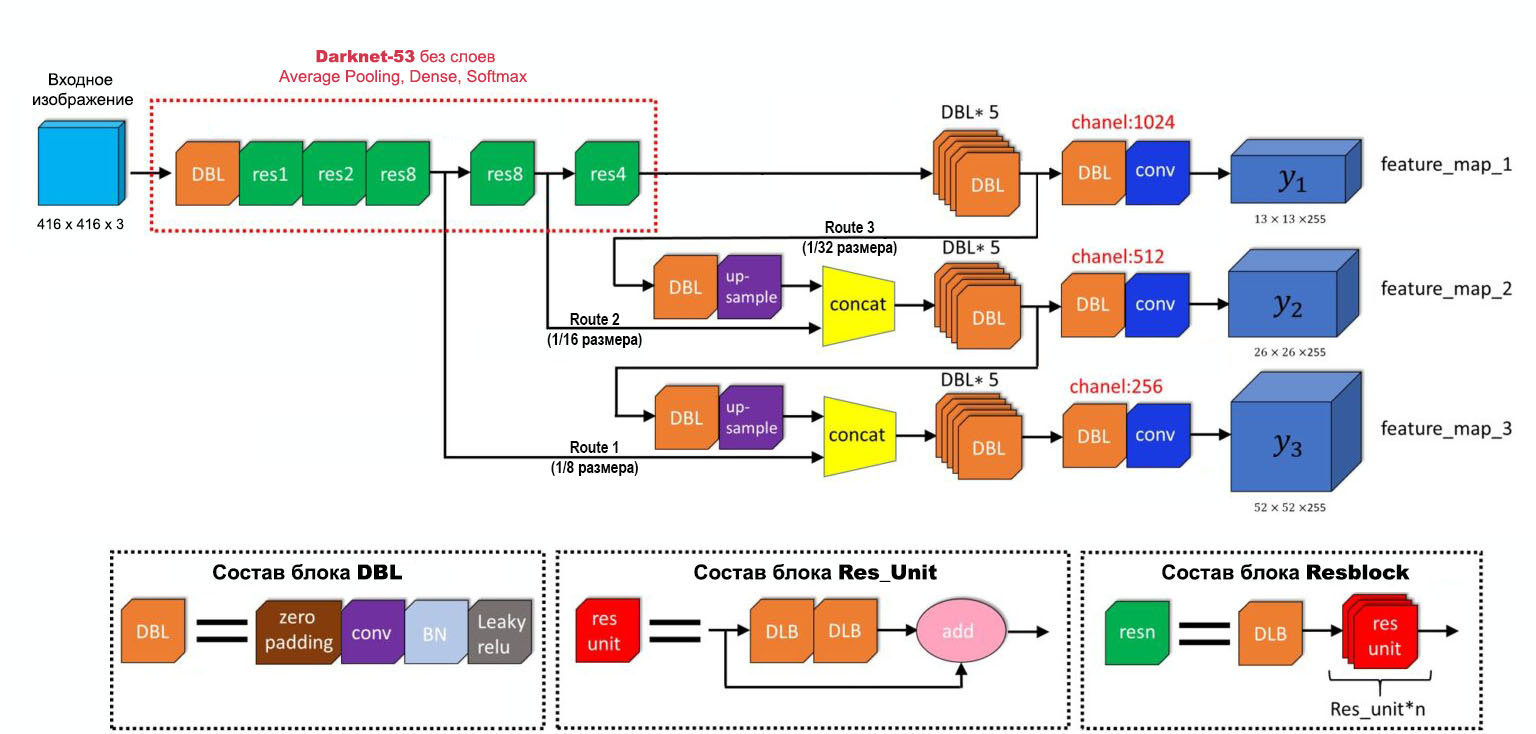

<div align='center'><b>Архитектура модели YOLOv.3</b>

<p>Для подбора значений якорных ячеек (anchor box) разрабочики использовали кластеризацию <b>K-Mean</b>. Были выбраны 9 кластеров и 3 масштаба, а затем каждый кластер был разделен по масштабам. Для набора данных COCO 9 кластеров распределены так:
$(10×13), (16×30), (33×23), (30×61), (62×45), (59×119), (116 × 90), (156 × 198), (373 × 326)$ 

В качестве каракаса модели для YOLOv3 мы возмем блоки и архитектуру сети Darknet. Последний сверточный слой из нее будет убран и добавлен в другую функцию для удобной компановки всей модели. <p>Итак, архитектура модели <b>YOLOv3</b>:

In [ ]:
# модель YOLOv3
input_image = Input(shape=(None, None, 3))
num_sub_anchors = 3
num_classes = 80
 
layer_idx = 0 # Номер первого слоя
x, layer_idx = DBL(input_image, filters=32, kernel=3, layer_idx=layer_idx)           # DarknetConv 1 слой
x, layer_idx = ResBlock(x, filters=64, blocks=1, layer_idx=layer_idx)                # DarknetBlock 3 слоя
x, layer_idx = ResBlock(x, filters=128, blocks=2, layer_idx=layer_idx)               # DarknetBlock 5 слоя
x, layer_idx = Route_1,_ = ResBlock(x, filters=256, blocks=8, layer_idx=layer_idx)   # DarknetBlock 9 слоев
x, layer_idx = Route_2,_ = ResBlock(x, filters=512, blocks=8, layer_idx=layer_idx)   # DarknetBlock 9 слоев
Route_3, layer_idx = ResBlock(x, filters=1024, blocks=4, layer_idx=layer_idx)        # последние 4 Res блока Darknet

bbox_scale_1, fork_1, layer_idx = Detector(Route_3, filters=512, layer_idx=layer_idx) # 5 сверточных слоев DBL

# 82 слой на первый выход  83 пропуск
layer_idx = 84
bbox_scale_2, fork_2, layer_idx = Detector([fork_1, Route_2], filters=256, layer_idx=layer_idx) # 6 слоев
 
# слои 94-95 пропущены
layer_idx = 96
bbox_scale_3, _, layer_idx = Detector([fork_2, Route_1], filters=128, layer_idx=layer_idx) # 6 слоев

model = Model (input_image, [bbox_scale_1, bbox_scale_2, bbox_scale_3])

model.summary()

Сеть имеет один вход, который принимает на вход изображение и 3 выхода с разных слоев, для изображений в 3-х масштабах.

## Якорные рамки (Anchor boxes)



В первой версии, YOLO, предсказывала координаты ограничивающих рамок (bounding box) напрямую, используя полносвязные слои следующие за сверточным экстрактором признаков (CNN), но это был не самый лучший вариант. 


Разработчики YOLO обратили внимание на подход, реализованный в Faster R-CNN. Вместо того, чтобы предсказывать координаты рамок напрямую, Faster R-CNN предсказывает ограничивающие рамки, отталкиваясь от первоначально выбранных вручную значений. 


Используя только сверточные слои RPN (region proposal network (сеть с предложенными регионами)) Faster R-CNN предсказывает смещение ограничивающих рамок относительно якорных. Поскольку предсказывающий слой является сверточным, RPN предсказывает эти смещения в каждом месте на карте признаков. Прогнозирование смещений вместо координат упрощает задачу локализации объектов и обучение сети.


Поэтому уже во второй версии YOLO, разработчики удалили предсказывающие полносвязные слои и ввели **anchor boxs** для предсказания ограничивающих  рамок.

Анкор боксы - это заранее созданные рамки, которые имеют различные, предварительно определенные соотношения сторон. Сеть может научиться сама подбирать размеры рамок, но если выбрать лучшие значения в начале обучения, то сети будет значительно проще локализовывать объекты.

Разработчики YOLO предлагают подбирать размеры анкор боксов путем кластеризации K-mean всего набора данных, на котором предстоит обучать сеть.  


Левое изображение (см. рис. 9) 9 показывает средние значения IOU (intersection over union, пересечение над объединением), которые получаются при различных вариантах k. 

Было обнаружено, что k=5 дает хороший компромисс между запоминанием и сложностью модели.


Правое изображение показывает относительные формыанкор боксов для VOC(черный) и COCO (синий). Оба набора анкор боксов предпочитают более тонкие и высокие рамки, так же СОСО, имеет больший разброс по размеру, чем VOC.


В третьей версии YOLO разработчики переработали нейросеть и добавили предсказание рамок в 3-х масштабах, а количество анкор боксов сделали равным трём.

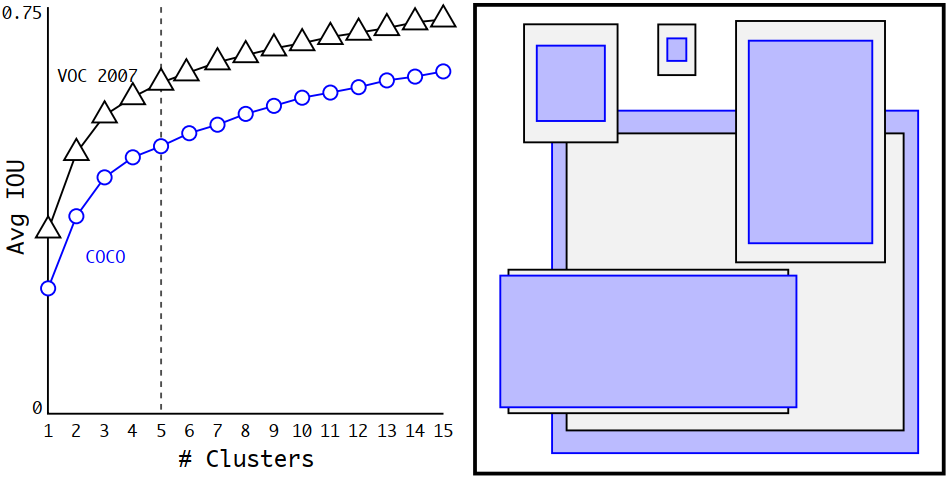

Рисунок 9. Пример кластеризации наборов данных СОСО и VOC 2007

### Сетка (якорное поле)




В далеком 2013 году алгоритмы обнаружения объектов использовали окно, которое перемещалось по всему изображению и выполняло классификацию изображений в каждом окне. Однако это настолько неэффективно, что исследователи предложили использовать сверточную сеть для одновременной оценки всего изображения. 

Поскольку свертка выводит квадратную карту признаков (например, 13x13, 26x26, и 52x52 в YOLO), мы рассматриваем эту карту признаков как сетку «якорное поле» и назначаем анкор боксы (якорные рамки) для каждой ячейки сетки. 

Другими словами, анкор боксы привязаны к ячейкам сетки и имеют один и тот же центроид. И после того, как мы определили анкор боксы, мы можем определить, насколько перекрывается ячейка сетки анкор боксом, и выбрать тот, который имеет лучшую IOU (intersection over union), а затем объединить их. 

Каждую ячейку сетки называют `Ground Truth Anchor Box`, чтобы не возникло путанницы будем называть `Ground Truth Anchor Box` - Базовыми анкор боксами.

На рисунке 10 приведен пример анкор боксов для карты признаков 13х13. В других размерах все будет аналогично, изменится только размер якорного поля и соответственно количество базовых анкор боксов $\implies 26\times 26\implies 52\times 52$. Размер анкор боксов подбирается под конкретный набор данных.

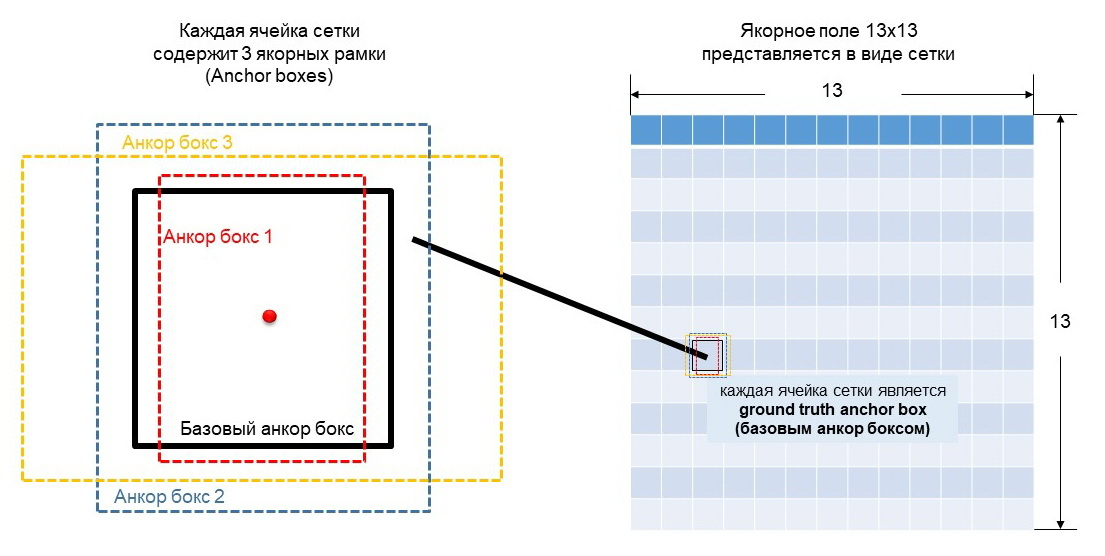

Рисунок 10. Анкор боксы (anchor boxes)

> Если минимальный размер анкор бокса будет больше, чем предполагаемый  минимальный размер обнаруживаемого объекта, то нейросеть никогда его не обнаружит, так как для такого анкор бокса не будет выполено условие IoU.

В YOLOv3 предполагается 3 анкор бокса на ячейку сетки, а так же сетки в трех масштабах. Таким образом получается для каждого масштаба 52х52х3 (8112) , 26х26х3 (2028), 13х13х3 (507) анкор боксов.


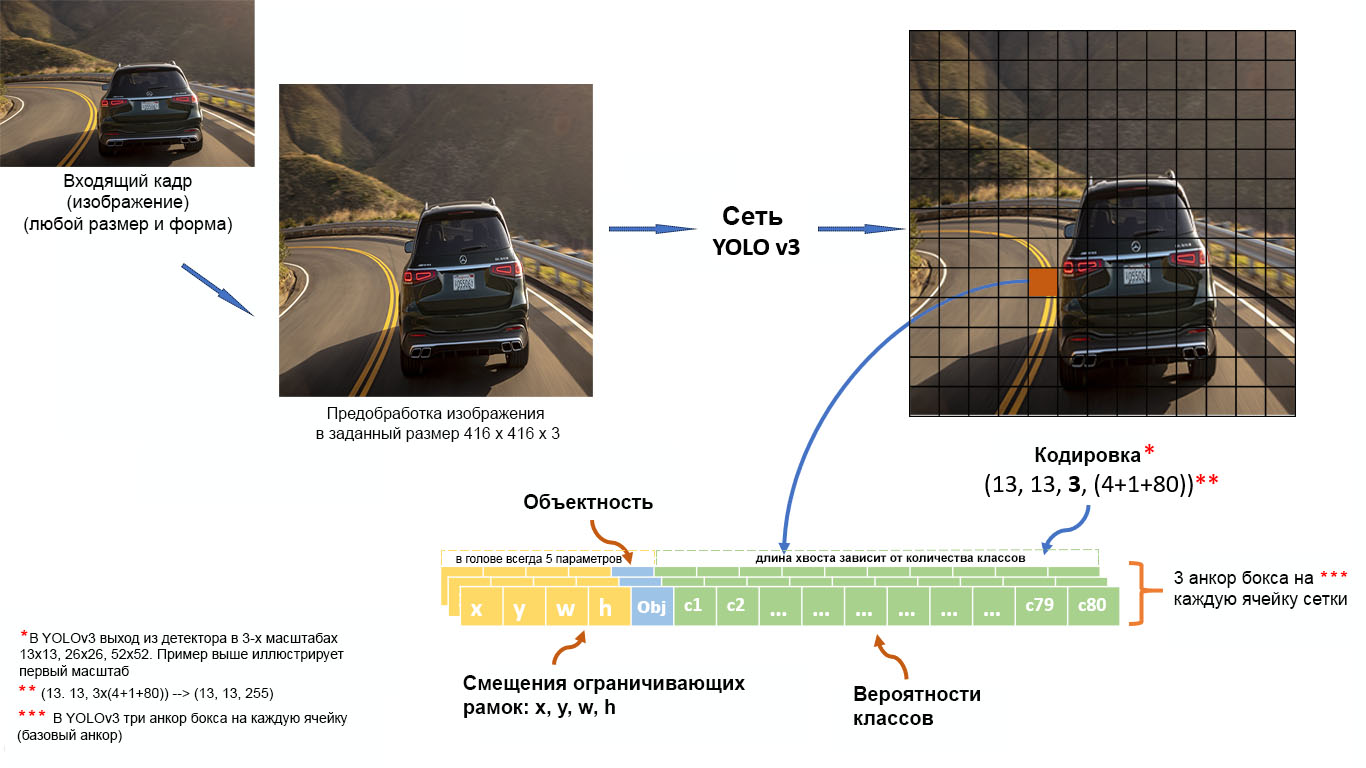

Рисунок 11. Предобработка изображения, наложение на него якорного поля, кодировка объектов

Для каждого <b>Анкор бокса</b> предсказывается три вещи:
- Смещение местоположения анкор бокса, относительно ее центрального расположения. $t_x, t_y, t_w, t_h$ всего 4 значения. $t_x, t_y, t_w, t_h$ - не настоящие координаты анкор бокса. Это смещения относительно базового анкора (ячейки сетки). Этот момент будет подробнее разобран ниже, при рассмотрении функции ошибки.
- Объектность (<b>objectness score</b>) - содержит ли данный анкор бокс какой-либо объект, принимает значения $0$ или $1$
- Вероятность класса, к которому принадлежит объект

В итоге, как уже упоминалось ранее, сеть предсказывает вектор 3 * 4+1+ num_classes для каждой ячейки сетки (базового анкор бокса). 

>Анкор боксы не только значительно усложняют реализацию детектора и делает его более подверженным ошибкам, но и вводят дополнительный шаг перед обучением. Если вы хотите получить наилучший результат, на вашем наборе данных. Вам необходимо провести исследование для определения оптимальных размеров анкор боксов. Поэтому идея анкор боксов - это скорее обход проблемы, чем ее реальное решение. В 2018 и 2019 годах исследователи начали сомневаться в необходимости анкор боксов. В таких статьях, как CornerNet, Object as Points и FCOS, обсуждалась возможность обучения детектора объектов с нуля без помощи анкор боксов.

<p>Объекты, особенно большие, обычно занимают центр изображения, поэтому для предсказания их локализации лучше иметь одно местоположение прямо в центре, чем четыре,которые находятся рядом. Для этого, чтобы иметь нечетное количество анкор боксов на изображении (или карте признаков, когда изображение уже прошло несколько сверточных слоев), чтобы был один центральный анкор бокс, рабочее разрешение выбрано 416х416 пикселей. Сверточные слои YOLO уменьшают изображение в 32 раза, поэтому используя входное разрешение 416х416 мы получаем выходную карту признаков 13х13.

## Функция ошибки
<p>Имея предсказание (выходной тензор с детектора) можно рассчитать ошибку относительно эталонных рамок (bounding boxes). 
<p>Функция ошибки (loss function) состоит из четырех частей: ошибка положения (xy) , ошибка ширины и высоты(wh), ошибка объектности (есть объект или его нет), ошибка классификации. Если сложить их вместе код будет выглядеть так:

In [ ]:
Loss = xy_loss + wh_loss + obj_loss + class_loss

Теперь разберем функцию ошибки по частям:


### xy_loss - ошибка локализации
Можно назвать еще ошибкой центра ограничивающей рамки (bounding box)

In [ ]:
xy_loss =  box_loss_scale * K.sum(K.square(true_xy - pred_xy), axis=-1) * obj_mask

<b>box_loss_scale</b> - это коэффициент, который был предложен разработчиками YOLO еще в первой версии. Предназначен для того, что бы регулировать баланс приоритета нейросети, при обучении, между локализации объектов и их классификацией. В оригинальной статье <b>box_loss_scale = 5</b>. В данной реализации вес рассчитывается в зависимости от размеров рамки. Чем больше анкор бокс, тем меньше ошибка.

true_xy - содержит значения $t_x$ и $t_y$ положение центра рамки (bounding box) по отношению к центру базового анкор бокса. 

pred_xy - содержит значения $t'_x$ и $t'_y$ предсказание центра рамки детектора. Чем меньше эта ошибка, тем ближе предсказанный ценр рамки к центру базового анкор бокса. Так как это задача регресси в качестве ошибки мы используем среднеквадратичную ошибку MSE

<p>Кроме того, какие то анкор боксы вообще могут не содержать объект, тогда мы вообще не включаем ошибки таких ячеек в итоговую оценку. Для этого в уравнении значение ошибки умножается на obj_mask

obj_mask принимает значения $0$ или $1$, что указывает на отсутствие или наличие объекта соответственно. Получаем из y_true.

Так же нам надо получить значения $t_x$ и $t_y$, центра текущей ячейки якорного поля (базового анкор бокса). 

<p>$b_x=\sigma(t_x)+C_x \\ b_y=\sigma(t_y)+C_y$
<p>Здесь $b_x$ и $b_y$ - это абсолютные значения центра рамки относительно всего якорного поля. 

Например: значения $b_x=0.5$ и $b_y=0.5$ означают, что это центральный анкор бокс на якорном поле (т.е. находится в центре изображения).

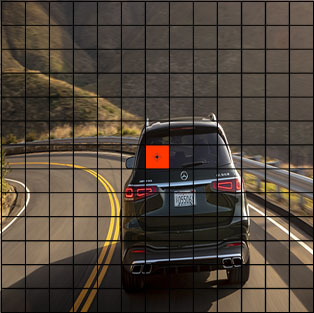

Рисунок 11. Абсолютный центр якорного поля $b_x=0.5$ и $b_y=0.5$

Однако сеть вычисляет центры рамок относительно верхнего левого угла якорного поля (сетки). 

**Важно!** Каждый якорный анкор бокс ограничен ячейкой сетки, т.е. он имеет один центроид с сеткой и с анкор боксами принадлежащими ему. Т.е. каждая ячейка соответствует своему набору анкор боксов.

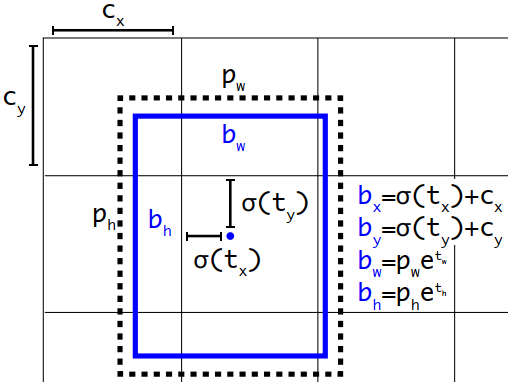

Рисунок 12. Принцип вычисления центра рамки и ее размера

В приведенной выше формуле $\sigma(t_x)$ и $\sigma(t_y)$ - это положение центра относительно ячейки сетки (в дальнейшем ячейки). Например, $\sigma(t_x)=0.5$ и $\sigma(t_y)=0.5$ означает, что центроид является центром текущей ячейки(но не всего изображения). 

$C_x$ и $C_y$ представляют собой абсолютные координаты верхнего левого угла текущей ячейки. Итак, если ячейка находится во ВТОРОЙ строке и ВТОРОМ столбце сетки 13x13, тогда $C_x = 1$ и $C_y = 1$. И, если мы добавим местоположение ячейки к относительному положению центроида, мы получим абсолютное местоположение центра рамки (bounding box) $b_x = 0.5 + 1$ и $b_y = 0.5 + 1$. 
Так же, что бы привести (нормировать) полученные значения к разным размера якорного поля (сетки), необходимо поделить эти значения на его текущий размер.
<p>Т.е. в приведенном примере $b_x = \frac{(0.5 + 1)}{13}=0.115$. 
<p> В финале, что бы получить $t_x$ из $b_x$ нужно его просто инвертировать. Кодовый блок приведенный ниже выполняет указанные действия.

In [ ]:
# бэкенд Keras
import tensorflow.keras.backend as K 

In [ ]:
# Решейпим y_pred[l]                 13                13              3              6
feats = K.reshape(y_pred[l], [-1, grid_shape[0], grid_shape[1], num_sub_anchors, num_classes + 5]) 
        
# Получаем координаты центра объекта из спредиктенного значения
pred_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats)) # три точки ... означают, что мы берем все параметры до запятой,

# Производим обратные вычесления для оригинальных значений из y_true для координат центра объекта
true_xy = y_true[l][..., :2] * grid_shapes[l][::-1] - grid  # Реальные координаты центра bounding_box
box_loss_scale = 2 - y_true[l][...,2:3] * y_true[l][...,3:4] # чем больше бокс, тем меньше ошибка

# В данном случае MSE заменили на binary_crossentropy для истинного значения и спредиктенного (obect_mask для подсчета только требуемого значения)
xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(true_xy, feats[...,0:2], from_logits=True)

### wh_loss - ошибка ширины и высоты
<P>Рассчитывается по формуле приведенной ниже.


In [ ]:
wh_loss =  box_loss_scale * K.sum(K.square(true_wh - pred_wh), axis=-1) * obj_mask

<p>$b_w=e^{t_w}*p_w \\ b_h=e^{t_h}*p_h$
<p>Здесь $b_w$ и $b_h$ - это абсолютная ширина и высотой рамки (bounding box). $p_w$ и $p_h$ - это заданная ширина и высота анкор бокса (изначально определены размеры 3х анкор боксов на каждую ячейку). 
<p>Мы берем здесь $e^{t_w}$ и $e^{t_h}$, потому что значения $t_w$ и $t_h$ могут быть отрицательным числом, но реальные ширина и высота, должна быть всегда положительными. Таким образом, exp () делает размеры всегда положительным. 
<p>Так как предсказания $t_w$ и $t_h$ основаны на предварительно определенных размерах анкор боксов мы умножаем  их $e^{t_w}$ на определенную ширину и высоту текущего(рассчитываемого) анкор бокса $p_w$ и $p_h$ соответственно. Итак, это умножение дает нам реальную ширину. 

Затем формула инвертируется, чтобы преобразовать $b_w$ и $b_h$ в $t_w$ и $t_h$ при вычислении ошибки.

<p> <b>box_loss_scale</b> и <b>obj_mask</b> выполняют те же функции, что и в ошибке, рассмотренной выше.

### IoU Пресечение над объединением
$IoU$ довольно простое понятие, которе можно выразить уравнением:
<div align='center'><font size='5'>$IoU = \frac{\mid A\bigcup B \mid}{\mid A\bigcap B\mid}$
</font><div align='left'> Выражает отношение площади пересечения рамок к общей площади занимаемой рамками. Используется чтобы исключить рамки (bounding box) в которых объект перекрыт на заданное пороговое значение.

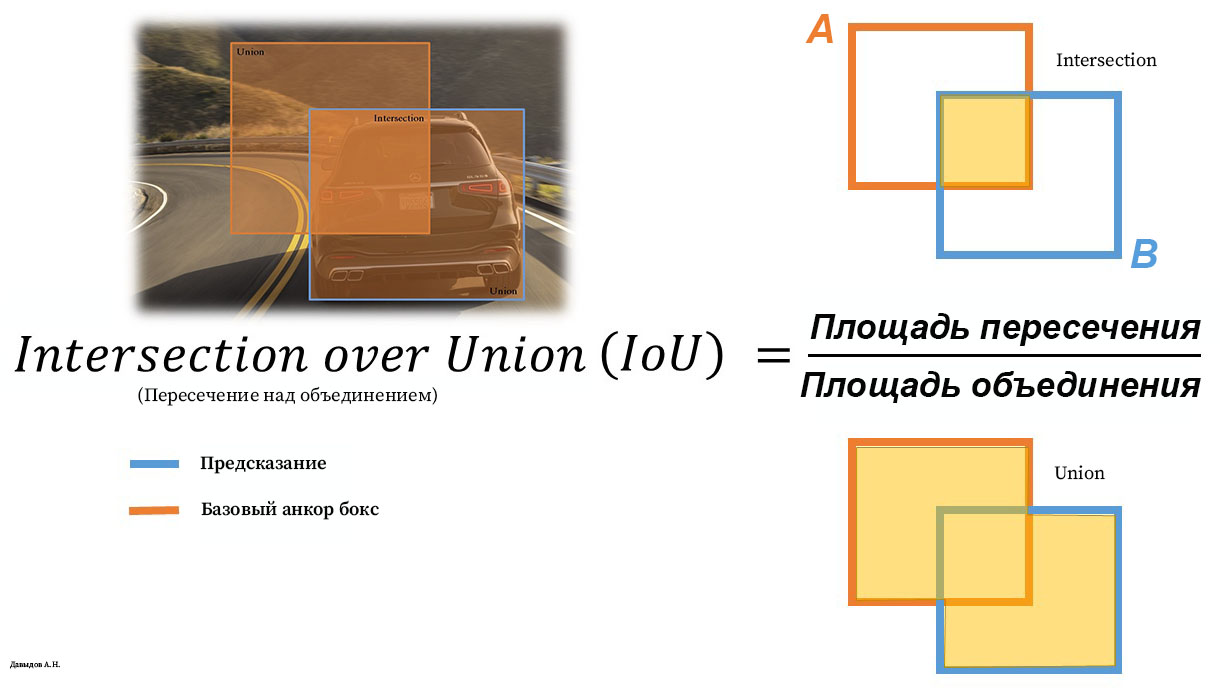

Рисунок 13. Иллюстрирует понятие IoU (пересечение над объединением)

In [ ]:
def _interval_overlap(interval_a, interval_b):

    ''' Функция рассчитывает интервал между углами рамок в зависимости от их взаимного расположения.
        Args:
            interval_a - координаты углов двух рамок по оси X.
            interval_b - координаты углов двух рамок по оси Y.
        Return:
            значение интервала между крайними точками.
    '''


    x1, x2 = interval_a # получаем координаты л.в. и п.н углов рамок
    x3, x4 = interval_b
    
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

In [ ]:
def intersectionOverUnion(box1, box2):

    ''' Функция рассчитывает отношение пересечение над объединениеми.
        Args:
            box1 - координаты рамки.
            box2 - координаты рамки.
        Return:
            значение IoU.
    '''

    intersect_w = interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect_area = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

    union_area = w1*h1 + w2*h2 - intersect_area
    
    return float(intersect_area) / union_area

### obj_loss ошибка объектности
Объектность указывает, насколько вероятно наличие объекта в текущей ячейки

In [ ]:
obj_loss = binary_crossentropy(true_obj, pred_obj)
obj_loss = obj_mask * obj_loss + obj_loss*(1 - obj_mask) * ignore_mask 

<p>По сути перед нами стоит задача классификации, так как <b>obj_mask</b> всегда равна $1$, для ячейки содержащей объект и $0$, для ячейки не содержащий объект. Используется стандартная для бинарной классификации функция `binary_crossentropy`. Уменьшая эту ошибку сеть учится находить интересующие нас области.

Так как мы не хотим, чтобы сеть предлагала ложные объекты повсюду, вторая строчка позволяет наказать модель за ложные срабатывания. Если `obj_mask = 0`, т.е. согласно y_true объекта в рамке нет, то первая часть уравнения будет равна 0, а нам нужно сохранить ошибку. Для этого мы добавляем второй член уравнения `obj_loss * (1 - obj_mask) * ignore_mask`. 

<p><b>Ignore_mask</b> используется, чтобы гарантировать, что мы будем учитывать ошибку только тогда, когда текущая рамка (bounding box)) не имеет большого перекрытия (<b>IoU</b>) с эталонной рамкой (из y_true), т.е. нейросеть хоть и "зацепила" реальный объект, но совсем чуть чуть. 

`ignore_mask` расчитывается в коде ниже. Используя функцию `tf.boolean_mask` мы убираем из  true_box рамки без объектов, записываем результат в переменную true_box_flat. Затем при помощи функции intersectionOverUnion рассчитываем значения `IoU` для предсказанных рамок и используя функцию `tf.reduce_max` сохраняем предсказанные рамки только с максимальным `IoU` в переменную `best_iou`. 

На завершающем этапе создаем маску, записываем в нее значения меньше заданного уровня `ignore_thresh`. Функция `tf.cast` задает формат значениям в float32. Стоит заметить, что так как в маску `ignore_mask` сохраняются значения `IoU`, то чем больше нейросеть ошиблась, тем выше будет итоговая ошибка obj_loss.

In [ ]:
# Импортируем tensorflow
import tensorflow as tf 

In [ ]:
# Подсчитываем все маски объектов
obj_mask = tf.squeeze(true_obj, -1)

# Игнорируем когда Intersection Over Union выше заданного порога (ignore_thresh)

# убираем рамки без объектов
true_box_flat = tf.boolean_mask(true_box, tf.cast(obj_mask, tf.bool)) 

# рассчитываем IoU и оставляем рамки с максимальным IoU
best_iou = tf.reduce_max(intersectionOverUnion(pred_box, true_box_flat), axis=-1) 

# записываем в переменную значения меньше уровня отсечки
ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32) 

### class_loss ошибка классификации


<p>Последняя составляющая ошибки, это ошибка классификации. Если мы имеем 80 классов, то они будут закодированы при помощи OHE в виде вектора из 80 значений. В YOLOv3 испольуется многоклассовая классификация вместо мульти классовой. 

Еще в YOLOv2 было проведено масштабное семантическое исследование, касающееся классов. Так многие классы не взаимоисключающие, а вложены, относительно друг друга. Например: женщина --> человек --> млекопитающее и т.д. Поэтому каждая выходная ячейка может определятся более, чем одним классом. 

Соответственно мы так же применяем `Binary_Cross_Entropy` для каждого класса один за другим и суммируем их, так как они не исключают друг друга. И так же как и с другими ошибками мы умножаем ее на `obj_mask`. 

Что бы учитывать только те ячейки в которых есть эталонный объект.

In [ ]:
# Используем вариацию binary_crossentropy или sparse_categorical_crossentropy в зависимости от подготовки данных

class_loss = obj_mask * binary_crossentropy( true_class_idx, pred_class)

Полная функция ошибки представлена в коде ниже:


In [ ]:
def yolo_loss(inputs, num_anchors):

    ''' Функция рассчитывает отношение пересечение над объединениеми.
        Args:
            box1 - координаты рамки.
            box2 - координаты рамки.
        Return:
            значение ошибки IoU.
    '''
    # Порог вероятности обнаружения объекта
    ignore_thresh = .5 
    
    # Подсчитываем количество анкоров на каждом уровне сетки
    num_layers = num_anchors // 3 
    
    # Из входных данных выцепляем посчитанные моделью значения
    y_pred = inputs[:num_layers] 
    
    # Из входных данных выцепляем эталонные значения
    y_true = inputs[num_layers:] 
    
    # Задаем маску анкоров для каждого уровня сеток
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]] 
   
    # Получаем размерность входного изображения ( (13 х 13) * 32 = (416 х 416)) и приводим к типу элемента y_true[0]
    input_shape = K.cast(K.shape(y_pred[0])[1:3] * 32, K.dtype(y_true[0])) 
    
    # Получаем двумерный массив, соответствующий размерностям сеток ((13, 13), (26, 26), (52, 52))
    grid_shapes = [K.cast(K.shape(y_pred[l])[1:3], K.dtype(y_true[0])) for l in range(num_layers)]
    
    loss = 0 # Значение ошибки
    
    # Размер пакета
    m = K.shape(y_pred[0])[0] 

    # Преобразуем к типу y_pred[0]
    batch_size = K.cast(m, K.dtype(y_pred[0])) 
    
    for l in range(num_layers): # Пробегаем по всем трем уровням сеток
       
        # Получаем маску для сетки l-го уровня по вероятности определения объекта (5-ый параметр в списке общих параметров). 
        # В массиве object_mask будут значения, которые соответствуют только вероятности обнаружения объекта
        object_mask = y_true[l][..., 4:5] # Вернется набор данных вида: ([0][0][0][0]...[1]...[0])
        
        # Получаем аналогичную выборку для сетки l-го уровня с OHE (где записана позиция нашего класса)
        # В массиве true_class будут значения, которые соответсвуют только OHE представлению класса ядля данного уровня анкоров
        true_class = y_true[l][..., 5:] # Вернется набор данных вида: ([0][0][0][0]...[1]...[0])
        
        num_sub_anchors = len(anchors[anchor_mask[l]]) # Получаем количество анкоров для отдельного уровян сетки (3)
        
        # Решейпим анкоры отдельного уровня сетки и записываем в переменную anchors_tensor
        anchors_tensor = K.reshape(K.constant(anchors[anchor_mask[l]]), [1, 1, 1, num_sub_anchors, 2])
        
        # Создаем двумерный массив grid со значениями [[[0, 0] , [0, 1] , [0, 2] , ... , [0, k]], 
        #                                             [[1, 0] , [1, 1] , [1, 2] , ... , [1 ,k]],
        #                                             ...
        #                                             [[k, 0] , [k, 1] , [k, 2] , ... , [k, k]]]
        # где k - размерность сетки. Массив хранит индексы ячеек сетки
        grid_shape = K.shape(y_pred[l])[1:3] # Получаем ширину и высоту сетки
        grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),[1, grid_shape[1], 1, 1]) # Создаем вертикальную линию
        grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),[grid_shape[0], 1, 1, 1]) # Создаем горизонтальную линию
        grid = K.concatenate([grid_x, grid_y]) # Объединяем 
        grid = K.cast(grid, K.dtype(y_pred[l])) # Приводим к типу y_pred[l]
        
        # Решейпим y_pred[l]                 13                13              3              6
        feats = K.reshape(y_pred[l], [-1, grid_shape[0], grid_shape[1], num_sub_anchors, num_classes + 5]) 
        
        # -- Считаем ошибку в определении координат центра объекта

        # Получаем координаты центра объекта из спредиктенного значения
        pred_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats)) # три точки ... означают, что мы берем все параметры до запятой ,
        # Производим обратные вычесления для оригинальных значений из y_true для координат центра объекта
        true_xy = y_true[l][..., :2] * grid_shapes[l][::-1] - grid  # Реальные координаты центра bounding_box
        box_loss_scale = 2 - y_true[l][...,2:3] * y_true[l][...,3:4] # чем больше бокс, тем меньше ошибка
        # binary_crossentropy для истинного значения и спредиктенного (obect_mask для подсчета только требуемого значения)
        xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(true_xy, feats[...,0:2], from_logits=True)

        # --- Считаем ошибку в определении координат ширины и высоты

        # Получаем значения ширины и высоты изображения из спредиктенного значения   
        pred_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats)) 
        # Производим обратные вычесления для оригинальных значений из y_true для ширины и высоты объекта
        true_wh = K.log(y_true[l][..., 2:4] / anchors[anchor_mask[l]] * input_shape[::-1]) 
        # Оставляем значение высоты и ширины только у тех элементов, где object_mask = 1
        true_wh = K.switch(object_mask, true_wh, K.zeros_like(true_wh)) 
        # Считаем значение ошибки в определении высоты и ширины
        wh_loss = object_mask * box_loss_scale * 0.5 * K.square(true_wh-feats[...,2:4])
        
        # Объединяем значения в один  массив
        pred_box = K.concatenate([pred_xy, pred_wh]) 
        
        # Считаем ошибку в определении обнаружения какого-либо класса
        # Для этого вначале надо отсечь все найденные объекты, вероятность которых меньше установленного значения ignore_thresh
        
        # Определяем массив, который будет хранить данные о неподходящих значениях
        ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True) 
        object_mask_bool = K.cast(object_mask, 'bool') # Приводим тип object_mask к типу 'bool'
        
        # Функция, определяющая данные, которые требуется игнорировать
        # Пробегаем по всем элементам пакета (b<m)
        # Получаем параметры реального bounding_box для текущей ячейки
        # Считаем IoU реального и спредиктенного
        # В зависимости от best_iou < ignore_thresh помечаем его как верно распознанный или неверено
        
        def loop_body(b, ignore_mask):

            ''' 
            Функция рассчитывает отношение пересечение над объединениеми.
            Args:
                b - элемент пакета
                ignore_mask - координаты рамки.
            Return:
                b+1 - следующий элемент пакета
                ignore_mask - координаты рамки.
             '''
            
            # в true_box запишутся первыые 4 параметра (центр, высота и ширина объекта) того элемента, значение которого в object_mask_bool равно True
            true_box = tf.boolean_mask(y_true[l][b,...,0:4], object_mask_bool[b,...,0]) 
            
            # Подсчитываем iou для спредиктенной ограничивающей рамки (pred_box) и оригинальной (true_box)
            iou = calc_iou(pred_box[b], true_box) 
            
            # Находим лучшую ограничивающую рамку
            best_iou = K.max(iou, axis=-1) 
            
            # Записываем в ignore_mask true или false в зависимости от (best_iou < ignore_thresh)
            ignore_mask = ignore_mask.write(b, K.cast(best_iou < ignore_thresh, K.dtype(true_box))) 
            
            return b+1, ignore_mask  
        
        # Пробегаем в цикле по всем элементам в пределах значения m (m = batch size)
        _, ignore_mask = tf.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask]) 
        ignore_mask = ignore_mask.stack() # Приводим ignore_mask к тензору
        ignore_mask = K.expand_dims(ignore_mask, -1) # Добавляем еще одну размерность в конце ignore_mask
                 
        # Считаем значение ошибки
        # 1 компонента - для значений, которые были верно спредиктены
        # 2 компонентя - для значения, которые были неверно спредиктены
        confidence_loss = (
            object_mask * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) +
            (1-object_mask) * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) * ignore_mask
            )
        
        # Считаем ошибку в определении класса объекта
        class_loss = object_mask * K.binary_crossentropy(true_class, feats[...,5:], from_logits=True)
    
        # Считаем суммарную ошибку
        xy_loss = K.sum(xy_loss) / batch_size
        wh_loss = K.sum(wh_loss) / batch_size
        confidence_loss = K.sum(confidence_loss) / batch_size
        class_loss = K.sum(class_loss) / batch_size
        loss += xy_loss + wh_loss + confidence_loss + class_loss
                
    return loss # Возвращаем значение ошибки   

## Постобработка Non Maximum Suppression
Последним компонтом системы обнаржуения является постобработка. Обычно постобработка сводится к таким простым вещам, как замена метки класса на понятное человеку название класса. 

Однако в задачах обнаружения объектов у нас  еще остается один важный шаг, для того, что бы предоставить окончательный, удобный для восприятия результат - <b><i>Non Maximum Suppression</b></i> (подавление не максимумов <b>NMS</b>). 

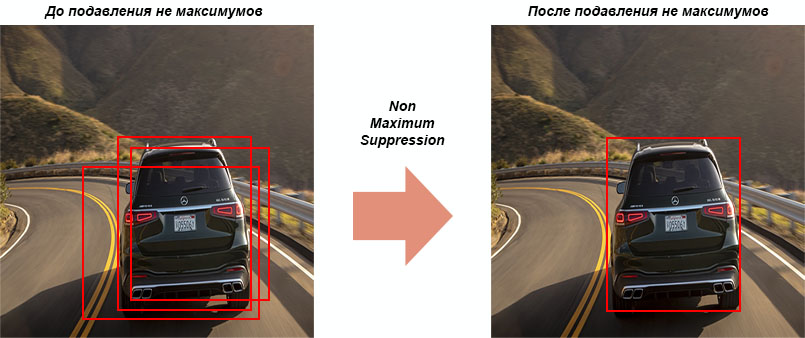

Рисунок 14. Постобработка Non Maximum Suppression

Модель YOLOv3 рассчитывает вероятности для 10 647 базовых анкор боксов. После вычисления параметра <b>objectness score</b>, все анкор боксы не содержащие объекты удаляются. Остаются только те, у которых вероятность содержания в них объекта выше заданной (пороговой). Далее вступает в действие алгоритм `NMS`

Алгоритм `NMS` берет две рамки (bounding boх) с наибольшими вероятностями, например 0.98 и 0.97 вычисляет между ними `IoU</b> и если значение превышает заданный порог, то данная рамка явно ограничивает один и тот же объект, соответственно рамку (bboх) с меньшей вероятностью (objectness) можно удалить. Затем берется следующая по вероятности рамка и т.д. до тех пор пока не останется только одна. 
<p>С другой стороны, если <b>IoU</b> ниже заданного порога, то скорее всего рамки описывают два разных объекта, в этом случае обе рамки остаются.
<p>Так же надо учитывать, что в YOLOv3 классы не взаимоисключающие, и каждое обнаружение может иметь более одного истинного класса. Поэтому существуют разные реализации алгоритма <b>NMS</b>, в каких то это учитывается, в каких то нет.

<p>Ниже представлен один из вариантов реализации алгоритма <b>NMS</b> функция <b>do_nms</b>

Фунция принимает на входы аргументы:
- boxes (tuple) - рамок bbox
- nms_thresh - (float32)- пороговое значение от 0 до 1, подбирается опытным путем.

Функция сортирует список рамок в порядке убывания вероятности, запоминает индекс первой рамки (с наибольшей вероятностью) в переменную `index_i`, индекс следующей за ней по вероятности в переменную `index_j`, далее при помощи функции `intersectionOverUnion`рассчитывается значение `IoU` и, если оно больше или равно заданному пороговому значению, то `nms_thresh` присваивает рамке с индексом `index_j`нулевую вероятность. 

Т.е. функция ничего не возвращает, а записывает результат прямо в список, которы пришел ей на вход. После подавления не максимумов, список `boxes`поступает в функцию `get_boxes`, которая пропускает все рамки с нулевой вероятностью, а по остальным, готовит информацию о классах и вероятности для вывода на экран.

In [ ]:
def do_nms(boxes, nms_thresh): 

    ''' 
    Функция  подавления лишних BBox Non Maximum Suppression
    
    Args:
        boxes - рамки 
        nms_thresh - пороговое значение
    Return: -

    '''
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if intersectionOverUnion(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

**Содержание темы**

1. Теория
2. [Практический ноутбук 1](https://colab.research.google.com/drive/1dri4Nx0VNsF9vZmF-qjN12AZBJ-eAdlY?usp=sharing)
3. [Практический ноутбук 2](https://colab.research.google.com/drive/1xJnAZG5CY1sZftGGG5Qq5Ze-ZveYHcRH?usp=sharing)
